<a href="https://colab.research.google.com/github/starovit/edu-fsdl-text-recognizer-2022-labs/blob/main/lab01/notebooks/hw_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1 download MNIST

from pathlib import Path
import requests

def download_mnist(path):
  url = "https://github.com/pytorch/tutorials/raw/main/_static/"
  filename = "mnist.pkl.gz"

  Path(path).mkdir(parents=True, exist_ok=True)
  content = requests.get(url + filename).content
  with open(path / filename, 'wb') as file:
      file.write(content)

  return path / filename

path = Path("data/")
datafile = download_mnist(path)

In [3]:
# 2 read MNIST

import gzip
import pickle

def read_mnist(path):
    with gzip.open(path, "rb") as f:
        # ignore test
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = read_mnist(datafile)

In [4]:
# 3 data to tensors

import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

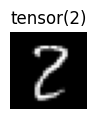

In [5]:
# 3 show random image

import random

def show_image(image: torch.Tensor, title: str):
  new_shape = (int(image.shape[0]**0.5), -1)
  image = image.reshape(new_shape)
  plt.figure(figsize=(1,1))
  plt.axis("off")
  plt.imshow(image, cmap="gray")
  plt.title(title)


index = random.randint(0, y_train.shape[0])
show_image(image = x_train[index], title = y_train[index])

In [6]:
def model(x: torch.Tensor) -> torch.Tensor:
  x = x @ weights + bias
  # x = torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdim=True)
  x = x - torch.log(torch.sum(torch.exp(x), axis=1))[:, None]
  return x

def accuracy(prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    prediction = torch.argmax(prediction, dim=1)
    return (prediction == target).float().mean()

def cross_entropy(prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
  return -prediction[range(target.shape[0]), target].mean()

In [7]:
epochs = 20
lr = 0.1

n = x_train.shape[0]
bs = 64

# initialization
weights = torch.randn(784, 10).requires_grad_()
bias = torch.randn(10).requires_grad_()
loss_func = cross_entropy

# learning loop
for epoch in range(epochs):
    for ii in range((n - 1) // bs + 1):
      # indexes
      start_idx = ii * bs
      end_idx = start_idx + bs

      # pull batches from x and from y
      xb = x_train[start_idx:end_idx]
      yb = y_train[start_idx:end_idx]

      # make prediction
      prediction = model(xb)
      loss = loss_func(prediction, yb)
      loss.backward()

      # update weights
      with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

    # print(loss)
    # print(f"epoch {epoch}: {accuracy(prediction, yb)}")

predicted: 9


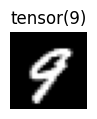

In [8]:
index = random.randint(0, y_train.shape[0])
show_image(image = x_train[index], title = y_train[index])

prediction = model(x_train[index][None, :]).argmax()
print(f"predicted: {prediction}")

# nn.Module

In [9]:
from torch import nn
import torch.nn.functional as F

class MNISTLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb: torch.Tensor) -> torch.Tensor:
      return self.lin(xb)

In [10]:
model = MNISTLogistic()
loss_func = F.cross_entropy

def fit():
    for epoch in range(epochs):
        for ii in range((n - 1) // bs + 1):
            start_idx = ii * bs
            end_idx = start_idx + bs
            xb = x_train[start_idx:end_idx]
            yb = y_train[start_idx:end_idx]

            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():  # finds params automatically
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [11]:
print(accuracy(model(xb), yb))

tensor(0.9375)


# Using dataset

In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [20]:
bs = 24
epochs = 20

In [21]:
%%time

class CustomDataset(Dataset):
  def __init__(
      self,
      data: torch.Tensor,
      targets: torch.Tensor
  ) -> None:
    super().__init__()
    self.data = data
    self.targets = targets

  def __len__(self) -> int:
    """Returns length of the dataset."""
    return self.targets.shape[0]

  def __getitem__(self, index: int):
    """Return a datum and its target."""
    datum, target = self.data[index], self.targets[index]
    return datum, target


dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False)

model = MNISTLogistic()
loss_func = F.cross_entropy

def fit():
    for epoch in range(epochs):
        for xb,yb in dataloader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():  # finds params automatically
                    p -= p.grad * lr
                model.zero_grad()

fit()

print(accuracy(model(xb), yb))

tensor(0.8750)
CPU times: user 28.7 s, sys: 64.1 ms, total: 28.8 s
Wall time: 29.2 s


In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # updated
device

In [23]:
%%time

class CustomDataset(Dataset):
  def __init__(
      self,
      data: torch.Tensor,
      targets: torch.Tensor
  ) -> None:
    super().__init__()
    self.data = data.to(device) # updated
    self.targets = targets.to(device) # updated

  def __len__(self) -> int:
    """Returns length of the dataset."""
    return self.targets.shape[0]

  def __getitem__(self, index: int):
    """Return a datum and its target."""
    datum, target = self.data[index], self.targets[index]
    return datum, target

dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False)

model = MNISTLogistic()
model.to(device) # updated

loss_func = F.cross_entropy

def fit():
    for epoch in range(epochs):
        for xb, yb in dataloader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():  # finds params automatically
                    p -= p.grad * lr
                model.zero_grad()

fit()


CPU times: user 30.9 s, sys: 1.15 s, total: 32 s
Wall time: 34.6 s
